1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
        Сгенерировать настоящие данные
        Изменить архитектуру дискриминатора и генератора
        Без графиков домашку не принимаю (реальные данные + результат модели, графики двух лоссов)
        Дополнительно: посмотреть зависимость от количества изначальных реальных данных (график)


In [4]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid


In [10]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [3]:
n_epochs = 10
batch_size = 32
lr = 0.001
latent_dim = 2
sample_interval = 100

x_min, x_max = -8, 8
x_len = 25600

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 16, normalize=False),
            *block(16, 32),
            *block(32, 16),
            nn.Linear(16, 2)
        )


    def forward(self, x):
        output = self.model(x)
        return output

In [5]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(0.3))
            return layers

        self.model = nn.Sequential(
            *block(2, 16),
            *block(16, 32),
            *block(32, 16),
            nn.Linear(16, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output


In [7]:
def func_y(x):
    return np.sin(x)/x - x/10
# print("Func_y:", func_y(x)) 

#данные два списка надо объединить в один вида data = [(x_0,y_0), (x_1, y_1),..] <- реальные данные 

In [8]:
x = np.linspace(x_min, x_max, x_len)
y = func_y(x)

train_data = torch.tensor(list(zip(x,func_y(x))))

In [9]:
train_data

tensor([[-8.0000,  0.9237],
        [-7.9994,  0.9236],
        [-7.9987,  0.9236],
        ...,
        [ 7.9987, -0.6762],
        [ 7.9994, -0.6762],
        [ 8.0000, -0.6763]], dtype=torch.float64)

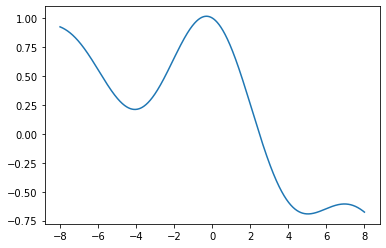

In [10]:
plt.plot(x, y)

In [11]:
real_data = torch.utils.data.DataLoader(train_data,
                                       batch_size=batch_size,
                                       shuffle=True)

In [12]:
generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

adversarial_loss = torch.nn.BCELoss()

In [13]:
import matplotlib.patches as mpatches

d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (train_values) in enumerate(real_data):

        batch_size = train_values.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_values = Variable(train_values.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_values = generator(z)

        validity = discriminator(gen_values)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_values)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_values.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            # plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_values)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            # display.display(plt.gcf())

            # d_loss_history.append(d_loss)
            # g_loss_history.append(g_loss)

            # plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            # plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            # plt.legend(handles=[red_patch, green_patch])
            # plt.show()

            

[Epoch 9/10] [Batch 700/800] [D loss: 0.689138] [G loss: 0.690503]


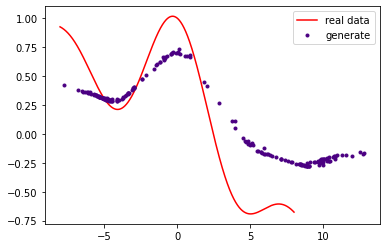

In [20]:
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (200,2)))).to(device)

plt.plot(x, y, 'r', label='real data', color = 'red')

pred = generator(z).detach().numpy()
plt.plot(pred[:,0], pred[:,1], '.', label='generate', color = 'indigo')
plt.legend()

In [14]:
stopit

2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [1]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

In [2]:
n_epochs = 10
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 25

img_shape = (channels, img_size, img_size)

In [14]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

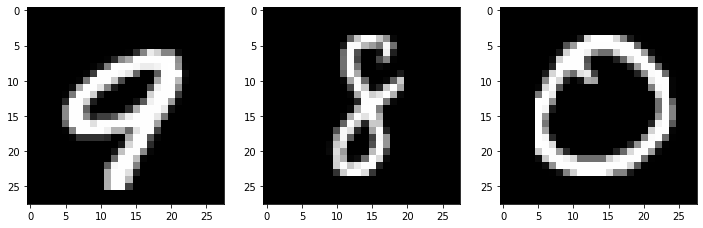

In [6]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])
img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(100, img_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size * 8, img_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size * 4, img_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(img_size, 1, 2, 2, 2, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)



In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(1, img_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size, img_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size * 2, img_size * 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

In [ ]:
import matplotlib.patches as mpatches

d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()

            